In [68]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor as SparkRandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

In [69]:
# Step 1: Create the SQLite database "fitbit.db"
conn = sqlite3.connect('fitbit.db')

In [70]:
#Step 2:
# Replace 'dailyCalories_merged.csv' with the actual name of your CSV file
csv_file = '/content/fitbit_df.csv'

In [71]:
# Load the CSV file into a DataFrame and create a table in the database
df_calories = pd.read_csv(csv_file)
table_name = csv_file.split(".")[0]
df_calories.to_sql(table_name, conn, if_exists='replace', index=False)

413

In [72]:
# Remove special characters and spaces from the CSV file name to create a valid table name
table_name = ''.join(e for e in csv_file.split(".")[0] if e.isalnum())

# Create a table in the database
df_calories.to_sql(table_name, conn, if_exists='replace', index=False)

413

In [73]:
# Step 2: Perform exploratory analysis and calculate correlation measures
query = f"SELECT * FROM {table_name}"
df_calories = pd.read_sql_query(query, conn)

In [74]:
# Calculate correlation matrix
correlation_matrix = df_calories.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                    SedentaryMinutes  TotalSteps  TotalMinutesAsleep  \
SedentaryMinutes            1.000000   -0.131632           -0.599394   
TotalSteps                 -0.131632    1.000000           -0.186866   
TotalMinutesAsleep         -0.599394   -0.186866            1.000000   
TotalTimeInBed             -0.618713   -0.164060            0.930457   
Calories                    0.095315    0.411996           -0.028526   

                    TotalTimeInBed  Calories  
SedentaryMinutes         -0.618713  0.095315  
TotalSteps               -0.164060  0.411996  
TotalMinutesAsleep        0.930457 -0.028526  
TotalTimeInBed            1.000000 -0.132507  
Calories                 -0.132507  1.000000  


In [75]:
# Step 4: Predict calories using tree-based machine learning models
# Load data and split into training and testing sets
X = df_calories.drop(['Calories'], axis=1)
y = df_calories['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [76]:
# Fit and evaluate the RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Report results
print("Results using RandomForestRegressor:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_rf))
print("R-squared (R2):", r2_score(y_test, y_pred_rf))

Results using RandomForestRegressor:
Mean Squared Error (MSE): 485141.5177554217
R-squared (R2): 0.2025221261646144


In [77]:
# Step 5: Implement a scalable workflow using PySpark for the best model
# Initialize Spark session
spark = SparkSession.builder.appName("FitBitModel").getOrCreate()

In [78]:
# Convert the pandas DataFrame to a Spark DataFrame
spark_df_calories = spark.createDataFrame(df_calories)

In [79]:
# Assemble features into a vector
feature_cols = df_calories.columns[:-1].tolist()  # Convert to list of strings
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
vector_df = assembler.transform(spark_df_calories)

In [80]:
# Split the data into training and testing sets
train_df, test_df = vector_df.randomSplit([0.8, 0.2], seed=42)

In [81]:
# Fit the RandomForestRegressor using PySpark
spark_rf = SparkRandomForestRegressor(featuresCol='features', labelCol='Calories')
rf_model_spark = spark_rf.fit(train_df)

In [82]:
# Predict on the test set
predictions_spark = rf_model_spark.transform(test_df)

In [83]:
# Selecting the columns of interest from the Spark DataFrame
predictions_spark = predictions_spark.select('Calories', 'prediction').toPandas()

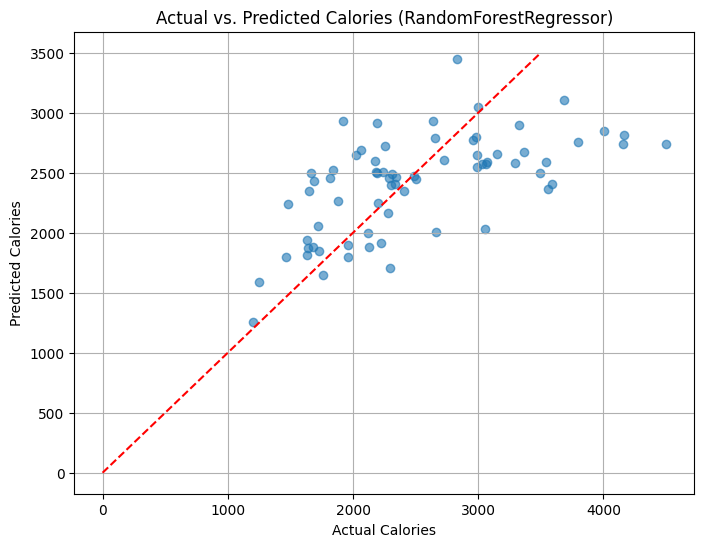

In [84]:
# Visualization: Scatter plot comparing actual vs. predicted calorie values
plt.figure(figsize=(8, 6))
plt.scatter(predictions_spark['Calories'], predictions_spark['prediction'], alpha=0.6)
plt.plot([0, 3500], [0, 3500], color='red', linestyle='--')  # Diagonal line (y=x) for reference
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.title('Actual vs. Predicted Calories (RandomForestRegressor)')
plt.grid(True)
plt.show()

In [86]:
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

In [88]:
print(type(predictions_spark))

<class 'pandas.core.frame.DataFrame'>


In [91]:
# Evaluate the model
mse_spark = mean_squared_error(predictions_spark['Calories'], predictions_spark['prediction'])
r2_spark = r2_score(predictions_spark['Calories'], predictions_spark['prediction'])

print("Mean Squared Error (MSE):", mse_spark)
print("R-squared (R2):", r2_spark)

Mean Squared Error (MSE): 378019.761651695
R-squared (R2): 0.3434360461381174


In [92]:
# Report results
print("Results using PySpark RandomForestRegressor:")
print("Mean Squared Error (MSE):", mse_spark)
print("R-squared (R2):", r2_spark)

Results using PySpark RandomForestRegressor:
Mean Squared Error (MSE): 378019.761651695
R-squared (R2): 0.3434360461381174


In [93]:
# Step 6: Predict calories using linear machine learning models
from sklearn.linear_model import LinearRegression

In [94]:
# Fit and evaluate the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [95]:
# Report results
print("Results using Linear Regression:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_lr))
print("R-squared (R2):", r2_score(y_test, y_pred_lr))

Results using Linear Regression:
Mean Squared Error (MSE): 462351.8490331438
R-squared (R2): 0.23998388916140112


In [96]:
# Close Spark session
spark.stop()

In [97]:
# Close SQLite connection
conn.close()